In [125]:
# %run common_imports.py
import seaborn as sns
%matplotlib qt
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")

%reload_ext autoreload
%autoreload 2
pd.options.display.max_rows = 600
pd.set_option('display.float_format', lambda x: '%.9f' % x)

dj.config['display.limit'] = 10**3  

os.environ["SPYGLASS_USE_TRANSACTIONS"] = "1"  
os.environ['KACHERY_API_KEY'] = "RhysjLwgmBAt2ObCyXXaDnqAv2kTdYRa"

import sys
import tuning_analysis.sorting_multiprocessing as smp
import spyglass.spikesorting.v1 as sgs
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from tuning_analysis.trial_extraction import *
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from tuning_analysis.spike_analysis import *
from pathlib import Path


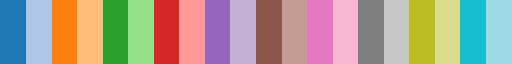

In [247]:
from cycler import cycler
cmap = 'tab20'
n_colors = 6
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0,1,n_colors)]
plt.rcParams["axes.prop_cycle"] = cycler(color = colors)
cmap

In [76]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Sans' 


In [5]:
graph = sgpl.TrackGraph() & {"track_graph_name":"Wtrack_wilbur20210512"}

### Plot unit-wise spiking locations

#### Fetch spikes

In [5]:
sorter_keys = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "mountainsort4",
    "curation_id": 2,
}

pfc_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(sorter_keys, restrict_by_artifact = True)

keys = [{"merge_id": merge_id} for merge_id in pfc_merge_ids]
(SpikeSortingOutput.CurationV1 & keys)

[12:17:59][WARNING] Spyglass: V0 requires artifact restrict. Ignoring "restrict_by_artifact" flag.


merge_id,sorting_id,curation_id
047f4da5-c1d4-ca9e-f923-cdb63c0d04e7,d14d9669-4f3e-47c8-bed9-e0cc90be7a71,2
0a29f32c-7036-e6bb-fd45-dc7ac35137fe,45539c29-3436-4633-b63d-f499fe8e4073,2
1a818a97-6f62-8d75-565f-7be81c6961c3,ee34cd1e-e742-4c73-bdae-9974c2b1d74a,2
3b2a05fa-9642-5ef4-58d7-1f8e9bf3e217,76904362-d49e-4883-98d1-442822ebb9a1,2
4db00acd-003c-de9a-b640-fb78fb276985,df857aaa-ccd8-4abf-82e2-e9b97706c162,2
6e499686-18c3-ef61-e344-d4e7d7c5e773,bae249c1-f797-4e38-83ee-a21f51684a20,2
70ca787c-23b6-feb6-84af-6e3ba338fdf3,1dd1e911-c185-4488-b607-83502ac5225f,2
d4644925-b88e-850f-36a2-291d1e1b99f7,48a2c037-f872-4a63-9ccb-1bd14cb727e4,2
e7eb99a4-da0e-a1ca-3be6-36e6037f9275,6868b312-14db-473b-ae34-ce1bd193055d,2
e9df24a9-9413-0623-2987-3064c50394ed,0c0d6f10-5af6-4add-beac-67f101ecb017,2


In [6]:
# get spikes from a specific group
group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "left mPFC",
}

SortedSpikesGroup().Units & group_key
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")

l_mpfc_spikes = SortedSpikesGroup().fetch_spike_data(group_key)


#### Fetch position

In [ ]:
epoch = 2
dlc_centroid_params_name = "four_paw_centroid"
pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "epoch": f"{epoch}", 
    "dlc_model_params_name": "WtrackSep5",
    "dlc_centroid_params_name": dlc_centroid_params_name  
}

merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

#### Plot

In [8]:
centroid_position = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()

In [107]:
# Single unit firing across all positions
unit = 4
spike_times = l_mpfc_spikes[unit]
spike_times = spike_times
spike_times = pd.Series([spike_time if spike_time < centroid_position.index[-1] else np.nan for spike_time in spike_times]).dropna().to_list()
spike_positions = np.searchsorted(centroid_position.index.tolist(), spike_times)
fig,ax = plt.subplots(layout = "tight")
ax.scatter(centroid_position.position_x, centroid_position.position_y, s = 4, color = 'k', alpha = 0.03)
ax.scatter(centroid_position.position_x.iloc[spike_positions], centroid_position.position_y.iloc[spike_positions], color = "#1188d8", s = 4, label = "spikes")
plt.legend();

### Extract trials

In [8]:
def get_centroid_and_linear_position(epoch: int,
                                     dlc_si_cohort_centroid: str = "four_paw_centroid_gap_15cm",
                                     linearization_param_name: str = "default"):
    merge_id = (PositionOutput.DLCPosV1() & {"epoch": epoch, "dlc_si_cohort_centroid": dlc_si_cohort_centroid}).fetch1("merge_id")
    centroid_df = (PositionOutput & {"merge_id": merge_id}).fetch1_dataframe()
    
    pos_merge_id = (PositionOutput.DLCPosV1() & {"dlc_si_cohort_centroid": dlc_si_cohort_centroid, "epoch": epoch}).fetch1("merge_id")
    linear_df =(sgpl.LinearizedPositionV1() & {"pos_merge_id":pos_merge_id, "linearization_param_name": linearization_param_name}).fetch1_dataframe()
    
    return centroid_df, linear_df

In [9]:
epoch2_centroid_df, epoch2_linear_df = get_centroid_and_linear_position(epoch=2,)
epoch4_centroid_df, epoch4_linear_df = get_centroid_and_linear_position(epoch=4, )
epoch6_centroid_df, epoch6_linear_df = get_centroid_and_linear_position(epoch=6,)
epoch8_centroid_df, epoch8_linear_df = get_centroid_and_linear_position(epoch=8,)


In [10]:
#get lick evenets and trial events
lick_events_df = prepare_DIO_data(session_restriction=session_restrict, lick_event_threshold=2)
trials_df = prepare_trial_data(lick_events_df)

[2026-01-02 11:36:36,835][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2026-01-02 11:37:03,543][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2026-01-02 11:37:03,560][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2026-01-02 11:37:03,576][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2026-01-02 11:37:03,593][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2026-01-02 11:37:03,610][WARNING]: Skipped checksum for file with has

In [11]:
# merge position information with all trials
target = pd.concat([epoch2_centroid_df, epoch2_linear_df], axis = 1)
e2_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch4_centroid_df, epoch4_linear_df], axis = 1)
e4_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch6_centroid_df, epoch6_linear_df], axis = 1)
e6_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch8_centroid_df, epoch8_linear_df], axis = 1)
e8_trialized_position = merge_trial_df_with_target(target, trials_df)



In [12]:
trialized_position = pd.concat([e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position], axis = 0)

maximum_trial_number_epoch_2 = e2_trialized_position["trial_number"].max()
maximum_trial_number_epoch_4 = e4_trialized_position["trial_number"].max()
maximum_trial_number_epoch_6 = e6_trialized_position["trial_number"].max()
maximum_trial_number_epoch_8 = e8_trialized_position["trial_number"].max()

trial_number_is_in_epoch_2 = (
    trialized_position["trial_number"] <= maximum_trial_number_epoch_2
)

trial_number_is_in_epoch_4 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_2)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_4)
)

trial_number_is_in_epoch_6 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_4)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_6)
)

trial_number_is_in_epoch_8 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_6)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_8)
)

trialized_position["epoch"] = np.select(
    condlist=[
        trial_number_is_in_epoch_2,
        trial_number_is_in_epoch_4,
        trial_number_is_in_epoch_6,
        trial_number_is_in_epoch_8,
    ],
    choicelist=[2, 4, 6, 8],
    default=np.nan,
)

rows_with_unassigned_epoch = trialized_position["epoch"].isna()
print(
    "error: ",
    trialized_position.loc[rows_with_unassigned_epoch, "trial_number"].unique(),
)

trialized_position

error:  []


,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed,linear_position,track_segment_id,projected_x_position,...,trial_duration (s),trial_label,trial_type,"trial_direction (previous, current, next)",left/right,speed_norm,trial_progress,trial_progress_distance,zone,epoch
time,,,,,,,,,,,,,,,,,,,,,
1620843475.612429380,83.000000000,130.841658279,64.731790850,-0.053658240,6.960407628,-0.472843676,6.976450064,316.186089589,2,130.840792016,...,31.147236824,error,NA,"(middle, left)",NaN,0.061862556,0.000412091,0.000000000,reward,2.000000000
1620843475.627006292,84.000000000,130.978969045,64.705678785,-0.042659516,6.028157129,-0.518424175,6.050408415,316.323341727,2,130.978043812,...,31.147236824,error,NA,"(middle, left)",NaN,0.053651030,0.000880091,0.000199549,reward,2.000000000
1620843475.641583204,85.000000000,131.088631994,64.655361196,-0.037588504,4.995344334,-0.563316860,5.027006157,316.432892087,2,131.087593898,...,31.147236824,error,NA,"(middle, left)",NaN,0.044576174,0.001348092,0.000358822,reward,2.000000000
1620843475.656160116,86.000000000,131.115555400,64.624931104,-0.037144367,3.894329998,-0.606435715,3.941265077,316.459747501,2,131.114449246,...,31.147236824,error,NA,"(middle, left)",NaN,0.034948538,0.001816092,0.000397867,reward,2.000000000
1620843475.670737267,87.000000000,131.126578252,64.618860540,-0.036747902,2.765255181,-0.646774325,2.839886132,316.470756776,2,131.125458493,...,31.147236824,error,NA,"(middle, left)",NaN,0.025182236,0.002284100,0.000413873,reward,2.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620851260.670865297,61922.000000000,124.689225906,64.985895988,0.083651418,32.215565491,-1.950195112,32.274539824,310.034239741,2,124.688957493,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.246826847,0.995921431,0.984448694,reward,8.000000000
1620851260.685442209,61923.000000000,126.176293610,64.933028473,-0.098815288,30.955147854,-2.056666277,31.023395282,311.521185732,2,126.175899780,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.237258436,0.996813590,0.988837991,reward,8.000000000
1620851260.700019360,61924.000000000,127.705623988,64.999964587,-0.088192557,29.599286213,-2.165808633,29.678417602,313.050661711,2,127.705371948,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.226972415,0.997705763,0.993352831,reward,8.000000000


In [ ]:
# save position data
# out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/") 
# out_dir.mkdir(parents=True, exist_ok=True)

# dataframes = [e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position, trialized_position]
# names = ["e2_trialized_position", "e4_trialized_position", "e6_trialized_position", "e8_trialized_position", "trialized_position"]

# for name, df in zip(names, dataframes):
#     df.to_csv(out_dir / f"{name}.csv", index=True)

In [7]:
e2_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e2_trialized_position.csv")
e4_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e4_trialized_position.csv")
e6_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e6_trialized_position.csv")
e8_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e8_trialized_position.csv")
trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/trialized_position.csv")

In [15]:
sns.set_context("poster")

In [16]:
# Plot trajectory for a single trial
trial = 12

t_start = trials_df.loc[trials_df["trial_number"] == trial, "trial_start"].iloc[0]
t_end = trials_df.loc[trials_df["trial_number"] == trial, "trial_end"].iloc[0]

# build boolean mask and select rows between the timestamps
mask = (l_centroid_df.index > t_start) & (l_centroid_df.index < t_end)
fig, ax = plt.subplots(layout = 'tight')
plot_background_position(l_centroid_df, ax)
l_centroid_df.loc[mask].plot.scatter(x = "position_x", y = "position_y", s = 8, ax = ax, c = l_centroid_df.loc[mask].index, cmap = "Blues")

NameError: name 'trials_df' is not defined

In [39]:
#plot various phases of a task
trial = 10


mask_reward = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "reward")
mask_run = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "run")
mask_turn = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "turn")

fig, ax = plt.subplots(figsize = (15, 15), layout = "tight")
plot_background_position( trialized_position.iloc[::20], ax)
# graph.plot_track_graph()
s = 40
trialized_position[mask_reward].plot.scatter(x = "position_x", y = "position_y", ax = ax,s = s )
trialized_position[mask_turn].plot.scatter(x = "position_x", y = "position_y", ax = ax, s=s)
trialized_position[mask_run].plot.scatter(x = "position_x", y = "position_y", ax = ax, s=s);

In [49]:
trial_mask = (trialized_position["trial_number"]==trial) &  (trialized_position["zone"]=="run")
timestamps = trialized_position[trial_mask]["time"] - trialized_position[trial_mask]["time"].iloc[0]
y = trialized_position[(trialized_position["trial_number"]==trial) & (trialized_position["zone"]=="run")]["speed"]
fig, ax = plt.subplots(figsize = (10,10), layout = "tight")
ax.plot(timestamps, y)

In [45]:
timestamps

17096    0.000000000
17097    0.014576912
17098    0.029153824
17099    0.043730736
17100    0.058307886
            ...     
17803   10.305893898
17804   10.320470810
17805   10.335047722
17806   10.349624634
17807   10.364201546
Name: time, Length: 712, dtype: float64

In [31]:
fig, ax = plt.subplots()
graph.plot_track_graph_as_1D(draw_edge_labels=True, ax = ax)
fig, ax = plt.subplots()
graph.plot_track_graph(draw_edge_labels=True, ax= ax)

### Behavior

In [168]:
#number of trials per epoch

In [178]:
print("num trials in epoch 2: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==2]["trial_number"]))))
print("num trials in epoch 4: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==4]["trial_number"]))))
print("num trials in epoch 6: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==6]["trial_number"]))))
print("num trials in epoch 8: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==8]["trial_number"]))))

num trials in epoch 2:  50
num trials in epoch 4:  56
num trials in epoch 6:  59
num trials in epoch 8:  56


In [181]:
#Incorrect trial numbers
print(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"]))
print(len(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"])))

[  1   2   3   4  53  54  56  64  98 104 122 124 126 136 154 156 168 170
 173 186 204]
21


In [8]:
#plot single trial trajectory and speed 
trial = 106
mask = (trialized_position["trial_number"]==trial) &( trialized_position["zone"]=="run")
timestamps = trialized_position[mask].index - trialized_position[mask].index.tolist()[0]
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, 2, layout = "tight", figsize = (20, 10))
    plot_background_position(trialized_position, ax[0], background_color="white")
    trialized_position[mask].plot.scatter(x = "position_x", y = "position_y", ax = ax[0], c = "speed", s = 20, vmin = 0, vmax = 80)
    ax[1].plot(timestamps, trialized_position[mask]["speed"])

### Spingle unit spikes/behavior tuning

#### Fetch spikes

In [61]:
def fetch_single_epoch_spikes(nwb_file_name: str,
                              sorted_spikes_group_nane: str):
    group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": sorted_spikes_group_nane
    }
    
    SortedSpikesGroup.Units & group_key
    
    group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
    return SortedSpikesGroup().fetch_spike_data(group_key)

In [ ]:
# l_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="left mPFC")


In [63]:
mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="mPFC")

In [ ]:
# out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/")
# out_dir.mkdir(parents=True, exist_ok=True)

# np.savez_compressed(out_dir / "mfpc_spikes.npz", *mpfc_spikes)


In [13]:
data = np.load("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/mfpc_spikes.npz", allow_pickle=True)
mpfc_spikes = [data[f"arr_{i}"] for i in range(len(data.files))]


#### Speed tuning

##### Compute tuning

In [ ]:
#rest vs run
mean_fr_df = rest_vs_run_firing_rates(mpfc_spikes, trialized_position[(trialized_position["track_segment_id"]==2)]
                                      , speed_threshold=5, segment_threshold=3)
plot_rest_vs_run_fr(mean_fr_df)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


In [ ]:
df = trialized_position.copy()
spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]

zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]
epochs = [2,4,6,8]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones)) & \
                    df["epoch"].isin(epochs)


speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
    df,
    spikes_list=spikes_list,
    mask=mask,
    column ="speed",
    binning="sliding",
    window_width=20,
    window_step=2,
    tuner_min=0,
    tuner_max=80,
    n_boot=500,
    random_state=0,
    peak_normalize = True
)




shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curv_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



In [463]:
plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed",
    n_units=40,
    s=3,
    color="tab:blue",
    peak_normalize = True,
    linewidth = 2,
    indices = speed_decreasing_unit_ids,
    
)

In [ ]:
#plot SINGLE UNIT tuning
def plot_unit_tuning_bootstrap(
    unit_id,
    tuning_dict,
    centers,
    lower_ci_dict,
    upper_ci_dict,
    *,
    ax=None,
    color="C0",
    marker="o",
    s=3.0,            
    linewidth=1.5,
    ci_alpha=0.25,
    show_ci=True,
    show_stderr=False,   
    ci=0.95,
    stderr_dict=None,   
    peak_normalize=False,  
    xlabel=None,
    ylabel=None,
    title=None,
    ylim=None,
):
    """
    Plot a single unit's bootstrapped tuning curve with CI band.

    Parameters
    ----------
    unit_id : int (or whatever keys your dicts use)
    tuning_dict/lower_ci_dict/upper_ci_dict : dict[unit_id] -> 1D array
    centers : 1D array of bin centers
    ax : matplotlib Axes (optional)
    s : markersize (NOT scatter 's')
    peak_normalize : uses scale = max(upper_ci) for that unit
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 3))

    if unit_id not in tuning_dict:
        raise KeyError(f"unit_id {unit_id!r} not found in tuning_dict keys (n={len(tuning_dict)}).")
    if unit_id not in lower_ci_dict or unit_id not in upper_ci_dict:
        raise KeyError(f"unit_id {unit_id!r} missing from lower/upper CI dicts.")

    x = np.asarray(centers, dtype=float)
    y = np.asarray(tuning_dict[unit_id], dtype=float)
    lo = np.asarray(lower_ci_dict[unit_id], dtype=float)
    hi = np.asarray(upper_ci_dict[unit_id], dtype=float)

    # optional peak normalization using CI-derived scale
    if peak_normalize:
        scale = np.nanmax(hi) if np.any(np.isfinite(hi)) else np.nan
        if np.isfinite(scale) and scale > 0:
            y = y / scale
            lo = lo / scale
            hi = hi / scale

            if stderr_dict is not None and unit_id in stderr_dict:
                stderr_dict = dict(stderr_dict)
                stderr_dict[unit_id] = np.asarray(stderr_dict[unit_id], dtype=float) / scale

    # main curve
    ax.plot(
        x, y,
        color=color,
        marker=marker,
        markersize=s,
        linewidth=linewidth,
    )

    # CI band
    if show_ci:
        ax.fill_between(x, lo, hi, color=color, alpha=ci_alpha, linewidth=0)

    # standard error (either provided, or inferred from CI width assuming normality)
    if show_stderr:
        if stderr_dict is not None and unit_id in stderr_dict:
            se = np.asarray(stderr_dict[unit_id], dtype=float)
        else:
            try:
                from statistics import NormalDist
                alpha = 1.0 - float(ci)
                z = NormalDist().inv_cdf(1.0 - alpha / 2.0)
            except Exception:
                z = 1.96  # fallback for ~95%
            se = (hi - lo) / (2.0 * z) if (np.isfinite(z) and z > 0) else np.full_like(y, np.nan)

        ok = np.isfinite(x) & np.isfinite(y) & np.isfinite(se) & (se >= 0)
        if np.any(ok):
            ax.errorbar(
                x[ok], y[ok],
                yerr=se[ok],
                fmt="none",
                ecolor=color,
                elinewidth=max(0.75, linewidth * 0.75),
                alpha=0.8,
                capsize=0,
            )

    # labels
    if xlabel is None:
        xlabel = "speed_norm"  # change if you're plotting something else
    if ylabel is None:
        ylabel = "Normalized firing rate" if peak_normalize else "Firing rate (Hz)"
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is None:
        title = f"unit {unit_id}"
    ax.set_title(title)

    if ylim is not None:
        ax.set_ylim(ylim)
    elif peak_normalize:
        ax.set_ylim(-0.05, 1.05)

    ax.axhline(0, color="k", linewidth=0.5, alpha=0.5)
    return ax


unit_to_plot = 20

fig, ax = plt.subplots(1, 1, figsize=(8,4))
plot_unit_tuning_bootstrap(
    unit_to_plot,
    speed_tuning, speed_centers, lo, hi,
    ax=ax,
    color="tab:blue",
    s=3,
    linewidth=2,
    peak_normalize=True,   
    xlabel="speed",
)
plt.tight_layout()
plt.show()


##### Stability within an epoch

In [465]:
#metric calculation 
def curve_corr(curve_a, curve_b, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    finite = np.isfinite(curve_a) & np.isfinite(curve_b)
    if finite.sum() < min_bins:
        return np.nan
    return float(np.corrcoef(curve_a[finite], curve_b[finite])[0, 1])

def mod_depth(curve):
    curve = np.asarray(curve, float)
    if np.all(~np.isfinite(curve)):
        return np.nan
    return float(np.nanmax(curve) - np.nanmin(curve))

def nrmse(curve_a, curve_b, eps=1e-6, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    finite = np.isfinite(curve_a) & np.isfinite(curve_b)
    if finite.sum() < min_bins:
        return np.nan
    rmse = np.sqrt(np.mean((curve_a[finite] - curve_b[finite]) ** 2))
    denom = max(mod_depth(curve_a), mod_depth(curve_b)) + eps
    return float(rmse / denom)

def peak_bin_shift(curve_a, curve_b, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    finite = np.isfinite(curve_a) & np.isfinite(curve_b)
    if finite.sum() < min_bins:
        return np.nan
    idx_a = np.where(finite)[0][np.argmax(curve_a[finite])]
    idx_b = np.where(finite)[0][np.argmax(curve_b[finite])]
    return float(abs(idx_a - idx_b))

def mean_rate(curve):
    curve = np.asarray(curve, float)
    return float(np.nanmean(curve)) if np.any(np.isfinite(curve)) else np.nan

def mean_rate_diff(curve_a, curve_b):
    ma = mean_rate(curve_a)
    mb = mean_rate(curve_b)
    if not np.isfinite(ma) or not np.isfinite(mb):
        return np.nan
    return float(abs(ma - mb))


In [490]:
# --- Early vs Late - for plotting one unit
df = trialized_position.copy()
spikes_list = mpfc_spikes.copy()

trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1, 2, 3, 4]
zones = ["run"]

base_mask = (
    df["trial_type"].isin(trial_types)
    & df["track_segment_id"].isin(track_segment_ids)
    & df["zone"].isin(zones)
)

epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)
e = epoch_vals[0]  


trials_e = np.sort(df.loc[base_mask & (df["epoch"] == e), "trial_number"].dropna().unique())
M = len(trials_e)
half = M // 2
early_trials = trials_e[:half]
late_trials  = trials_e[half:]
print(f"epoch {e}: n_trials={M} (early={len(early_trials)}, late={len(late_trials)})")

mask_early = base_mask & (df["epoch"] == e) & (df["trial_number"].isin(early_trials))
mask_late  = base_mask & (df["epoch"] == e) & (df["trial_number"].isin(late_trials))


column = "speed"     
tuner_min = 10
tuner_max = 100
window_width = 20
window_step  = 2

common_kwargs = dict(
    spikes_list=spikes_list,
    column=column,
    binning="sliding",      
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
    peak_normalize=True,        
)

tun_early, centers, lo_early, hi_early, *_ = compute_tuning_bootstrap_trials(
    df, mask=mask_early, **common_kwargs
)
tun_late, centers2, lo_late, hi_late, *_ = compute_tuning_bootstrap_trials(
    df, mask=mask_late, **common_kwargs
)

if not np.allclose(centers, centers2, equal_nan=True):
    raise ValueError("Early/Late centers differ; ensure tuner_min/max and window_width/step are identical.")


Epochs: [2.0, 4.0, 6.0, 8.0]
epoch 2.0: n_trials=45 (early=22, late=23)


In [493]:
# ---- plot one unit: overlay early and late on the same axis ----
unit_to_plot = 14

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plot_unit_tuning_bootstrap(
    unit_to_plot,
    tun_early, centers, lo_early, hi_early,
    ax=ax,
    s=4,
    linewidth=2,
    peak_normalize=False,    # already normalized in compute_tuning_bootstrap_trials
    color = "tab:blue",
    xlabel=column,
    title=None,
    ci_alpha=0.18,
)

plot_unit_tuning_bootstrap(
    unit_to_plot,
    tun_late, centers, lo_late, hi_late,
    ax=ax,
    s=4,
    linewidth=2,
    color = "tab:red",
    peak_normalize=False,    # already normalized in compute
    xlabel=column,
    title=None,
    ci_alpha=0.18,
)

# ax.set_title(f"Unit {unit_to_plot} (epoch {e}): early vs late (continuous bins)")
ax.legend(["early", "early CI", "late", "late CI"], frameon=False)  # optional; depends on your function behavior
plt.tight_layout()
plt.show()


In [477]:
# --- CONTINUOUS / SLIDING-WINDOW VERSION ---

df = trialized_position.copy()

base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)

e = epoch_vals[0]
trials_e = np.sort(df.loc[base_mask & (df["epoch"] == e), "trial_number"].dropna().unique())

M = len(trials_e)
print(e, M)
half = M // 2
contig_A = trials_e[:half]
contig_B = trials_e[half:]

spikes_list = mpfc_spikes.copy()

# --- sliding-window parameters (speed_norm is [0,1]) ---
window_width = 0.20   # window size in speed_norm units
window_step  = 0.02   # step size; smaller => more bins

def tuning_for_trials(epoch_val, trial_subset, n_boot=200, seed=0, spikes_list = spikes_list, peak_normalize = True):
    # Returns exactly (tuning, centers) so downstream unpacking works in all sections.
    # (n_boot/seed are accepted for API compatibility but unused here.)
    m = base_mask & (df["epoch"] == epoch_val) & (df["trial_number"].isin(trial_subset))
    tuning, centers = compute_tuning(
        df,
        column="speed_norm",
        spikes_list=spikes_list,
        n_bins=8,  # ignored for binning='sliding'
        mask=m,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=0.0,
        tuner_max=1.0,
        peak_normalize=peak_normalize,
    )
    return tuning, centers

tunA, centers, *_ = tuning_for_trials(e, contig_A)
tunB, centersB, *_ = tuning_for_trials(e, contig_B)

# sanity check: centers should match
if not np.allclose(centers, centersB, equal_nan=True):
    raise ValueError("Sliding-window centers differ between splits; check your binning params.")

units = sorted(tunA.keys())
print("n_centers:", len(centers))


Epochs: [2.0, 4.0, 6.0, 8.0]
2.0 45
n_centers: 41


In [478]:
# metrics for contigous epoch split

contiguous_curve_correlation = {}
contiguous_curve_nrmse = {}
contiguous_peak_shift_bins = {}
contiguous_mean_rate_diff = {}

for unit_id in units:
    curve_first_half = tunA[unit_id]
    curve_second_half = tunB[unit_id]

    contiguous_curve_correlation[unit_id] = curve_corr(curve_first_half, curve_second_half)
    contiguous_curve_nrmse[unit_id] = nrmse(curve_first_half, curve_second_half)
    contiguous_peak_shift_bins[unit_id] = peak_bin_shift(curve_first_half, curve_second_half)
    contiguous_mean_rate_diff[unit_id] = mean_rate_diff(curve_first_half, curve_second_half)

print("Contiguous split summary:")
print("  median corr:", np.nanmedian(list(contiguous_curve_correlation.values())))
print("  median nrmse:", np.nanmedian(list(contiguous_curve_nrmse.values())))
print("  median peak shift (bins):", np.nanmedian(list(contiguous_peak_shift_bins.values())))
print("  median mean-rate diff:", np.nanmedian(list(contiguous_mean_rate_diff.values())))


Contiguous split summary:
  median corr: 0.38202301707230096
  median nrmse: 0.3553185764921993
  median peak shift (bins): 8.0
  median mean-rate diff: 0.09764970068093126


/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [479]:

random_split_runs = 50
rng = np.random.default_rng(0)

null_curve_correlation = {unit_id: [] for unit_id in units}
null_curve_nrmse = {unit_id: [] for unit_id in units}
null_peak_shift_bins = {unit_id: [] for unit_id in units}
null_mean_rate_diff = {unit_id: [] for unit_id in units}

for run_idx in range(random_split_runs):
    permuted_trials = rng.permutation(trials_e)
    trials_split_A = permuted_trials[:half]
    trials_split_B = permuted_trials[half:]

    tuning_A, _, *_ = tuning_for_trials(e, trials_split_A, n_boot=200, seed=run_idx + 1)
    tuning_B, _, *_ = tuning_for_trials(e, trials_split_B, n_boot=200, seed=1000 + run_idx + 1)

    for unit_id in units:
        curve_A = tuning_A[unit_id]
        curve_B = tuning_B[unit_id]

        null_curve_correlation[unit_id].append(curve_corr(curve_A, curve_B))
        null_curve_nrmse[unit_id].append(nrmse(curve_A, curve_B))
        null_peak_shift_bins[unit_id].append(peak_bin_shift(curve_A, curve_B))
        null_mean_rate_diff[unit_id].append(mean_rate_diff(curve_A, curve_B))


In [480]:

# ---------- per-unit p-values (contiguous vs null) ----------
# For corr: low is worse -> p = P(null <= contig)
# For others: high is worse -> p = P(null >= contig)
p_corr = {}
p_nrmse = {}
p_peak_shift = {}
p_mean_rate_diff = {}

for unit_id in units:
    null_c = np.asarray(null_curve_correlation[unit_id], float)
    null_e = np.asarray(null_curve_nrmse[unit_id], float)
    null_p = np.asarray(null_peak_shift_bins[unit_id], float)
    null_m = np.asarray(null_mean_rate_diff[unit_id], float)

    null_c = null_c[np.isfinite(null_c)]
    null_e = null_e[np.isfinite(null_e)]
    null_p = null_p[np.isfinite(null_p)]
    null_m = null_m[np.isfinite(null_m)]

    contig_c = contiguous_curve_correlation[unit_id]
    contig_e = contiguous_curve_nrmse[unit_id]
    contig_p = contiguous_peak_shift_bins[unit_id]
    contig_m = contiguous_mean_rate_diff[unit_id]
    p_corr[unit_id] = np.nan if null_c.size == 0 else float(np.mean(null_c <= contig_c))
    p_nrmse[unit_id] = np.nan if null_e.size == 0 else float(np.mean(null_e >= contig_e))
    p_peak_shift[unit_id] = np.nan if null_p.size == 0 else float(np.mean(null_p >= contig_p))
    p_mean_rate_diff[unit_id] = np.nan if null_m.size == 0 else float(np.mean(null_m >= contig_m))


In [481]:
#label units
alpha = 0.05

within_epoch_shape_drift = {}
within_epoch_rate_drift = {}
within_epoch_status = {}

for unit_id in units:
    if (not np.isfinite(p_corr[unit_id]) or
        not np.isfinite(p_nrmse[unit_id]) or
        not np.isfinite(p_peak_shift[unit_id]) or
        not np.isfinite(p_mean_rate_diff[unit_id])):
        within_epoch_status[unit_id] = "insufficient"
        within_epoch_shape_drift[unit_id] = False
        within_epoch_rate_drift[unit_id] = False
        continue

    # shape metrics: correlation and peak shift
    shape_drift = (p_corr[unit_id] < alpha) and (p_peak_shift[unit_id] < alpha)
    # rate metrics: rate diff and nrmse
    rate_drift = (p_nrmse[unit_id] < alpha) and (p_mean_rate_diff[unit_id] < alpha)

    within_epoch_shape_drift[unit_id] = shape_drift
    within_epoch_rate_drift[unit_id] = rate_drift

    if shape_drift or rate_drift:
        within_epoch_status[unit_id] = "drifting"
    else:
        within_epoch_status[unit_id] = "stationary"

print("\nWithin-epoch labels (alpha=0.05):")
print("  stationary:", sum(v == "stationary" for v in within_epoch_status.values()))
print("  drifting:", sum(v == "drifting" for v in within_epoch_status.values()))
print("  insufficient:", sum(v == "insufficient" for v in within_epoch_status.values()))

print("\nDrift type:")
print("  shape drift:", sum(within_epoch_shape_drift.values()))
print("  rate drift:", sum(within_epoch_rate_drift.values()))

median_of_unit_median_null_corr = np.nanmedian([np.nanmedian(null_curve_correlation[u]) for u in units])
median_of_unit_median_null_nrmse = np.nanmedian([np.nanmedian(null_curve_nrmse[u]) for u in units])

print("\nNull baseline (median across units of per-unit median):")
print("  corr:", median_of_unit_median_null_corr)
print("  nrmse:", median_of_unit_median_null_nrmse)



Within-epoch labels (alpha=0.05):
  stationary: 212
  drifting: 47
  insufficient: 4

Drift type:
  shape drift: 13
  rate drift: 35

Null baseline (median across units of per-unit median):
  corr: 0.5506672287386056
  nrmse: 0.27138340355276735


/tmp/ipykernel_4036015/2753853428.py:40: RuntimeWarning: All-NaN slice encountered
  median_of_unit_median_null_corr = np.nanmedian([np.nanmedian(null_curve_correlation[u]) for u in units])


In [488]:
#plot null metric distribution for one cell
def plot_null_metric_histograms_for_unit(
    unit_id,
    *,
    null_curve_correlation,
    null_curve_nrmse,
    null_peak_shift_bins,
    percentile=5,           # e.g. 5 -> “worst 5%” threshold
    tail="auto",            # "auto" | "lower" | "upper"
    bins=30,
    figsize=(12, 4),
    color="0.35",
    line_color="tab:red",
    alpha=0.75,
    suptitle=None,
):
    """
    Plot histograms of null metrics for a single unit (corr, nrmse, peak_shift_bins),
    with a percentile threshold line.

    tail="auto": uses lower tail for correlation (low corr is "worse"),
                 upper tail for nrmse/peak_shift (high is "worse").
    """
    metric_map = {
        "corr": null_curve_correlation,
        "nrmse": null_curve_nrmse,
        "peak_shift_bins": null_peak_shift_bins,
    }

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes = np.atleast_1d(axes).ravel()

    for ax, (name, per_unit_dict) in zip(axes, metric_map.items()):
        if unit_id not in per_unit_dict:
            raise KeyError(f"unit_id {unit_id!r} not found for metric {name!r}")

        vals = np.asarray(per_unit_dict[unit_id], dtype=float)
        vals = vals[np.isfinite(vals)]

        if vals.size == 0:
            ax.set_title(f"{name} (no finite values)")
            ax.axis("off")
            continue

        # choose which tail percentile to show
        tail_mode = tail
        if tail_mode == "auto":
            tail_mode = "lower" if name == "corr" else "upper"

        if tail_mode == "lower":
            q = float(percentile)
        elif tail_mode == "upper":
            q = 100.0 - float(percentile)
        else:
            raise ValueError("tail must be 'auto', 'lower', or 'upper'")

        q = np.clip(q, 0.0, 100.0)
        thr = float(np.nanpercentile(vals, q))

        ax.hist(vals, bins=bins, color=color, alpha=alpha, edgecolor="white", linewidth=0.5)
        ax.axvline(thr, color=line_color, linewidth=2, label=f"{q:.1f}th pct = {thr:.4g}")
        ax.set_title(f"{name} (unit {unit_id})")
        ax.set_xlabel(name)
        ax.set_ylabel("count")
        ax.legend(frameon=False)

    if suptitle is None:
        suptitle = f"Null metric histograms for unit {unit_id}"
    fig.suptitle(suptitle)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    return fig, axes


# ---- Example usage ----
unit_to_plot = units[7]  # or any unit id you want
plot_null_metric_histograms_for_unit(
    unit_to_plot,
    null_curve_correlation=null_curve_correlation,
    null_curve_nrmse=null_curve_nrmse,
    null_peak_shift_bins=null_peak_shift_bins,
    percentile=5,
    tail="auto",
    bins=25,
)
plt.show()


In [495]:
def illustrate_pvalue_rule_for_unit(
    unit_id,
    *,
    null_metric_dict,          # e.g. null_curve_correlation
    contig_metric_dict,        # e.g. contiguous_curve_correlation
    alpha=0.05,
    direction="lower",         # "lower" for corr (low is worse), "upper" for nrmse/peak_shift (high is worse)
    bins=25,
    ax=None,
    hist_color="0.35",
    hist_alpha=0.75,
    contig_color="tab:blue",
    thresh_color="tab:red",
    shade_color="tab:red",
    shade_alpha=0.15,
    title=None,
    xlabel=None,
):
    null_vals = np.asarray(null_metric_dict[unit_id], dtype=float)
    null_vals = null_vals[np.isfinite(null_vals)]
    contig_val = float(contig_metric_dict[unit_id])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.figure

    if null_vals.size == 0 or not np.isfinite(contig_val):
        ax.set_title(f"unit {unit_id}: insufficient data")
        return fig, ax

    # p-value rule
    if direction == "lower":
        p = float(np.mean(null_vals <= contig_val))
        q = 100.0 * float(alpha)            # left-tail threshold
    elif direction == "upper":
        p = float(np.mean(null_vals >= contig_val))
        q = 100.0 * (1.0 - float(alpha))    # right-tail threshold
    else:
        raise ValueError("direction must be 'lower' or 'upper'")

    sig = p < alpha
    thresh = float(np.nanpercentile(null_vals, q))

    # histogram FIRST (sets reasonable x-limits)
    ax.hist(null_vals, bins=bins, color=hist_color, alpha=hist_alpha, edgecolor="white", linewidth=0.5)

    # get finite axis limits and compute shading span
    xmin, xmax = ax.get_xlim()
    if not np.isfinite(xmin) or not np.isfinite(xmax):
        xmin = float(np.nanmin(null_vals))
        xmax = float(np.nanmax(null_vals))
        ax.set_xlim(xmin, xmax)
        xmin, xmax = ax.get_xlim()

    if direction == "lower":
        x0 = xmin
        x1 = min(thresh, xmax)
    else:
        x0 = max(thresh, xmin)
        x1 = xmax

    # only shade if the span has positive width
    if np.isfinite(x0) and np.isfinite(x1) and (x1 > x0):
        ax.axvspan(
            x0, x1,
            color=shade_color,
            alpha=shade_alpha,
            zorder=0,
            label=f"rejection region (α={alpha})",
        )

    # draw threshold + observed value
    ax.axvline(thresh, color=thresh_color, linewidth=2, linestyle="--",
               label=f"null threshold = {thresh:.3g}")
    ax.axvline(contig_val, color=contig_color, linewidth=2,
               label=f"contig = {contig_val:.3g}")

    # annotate p-value
    ax.text(
        0.02, 0.98,
        f"p = {p:.4g}\n(sig @ α={alpha}: {sig})",
        transform=ax.transAxes,
        va="top", ha="left",
        # fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="0.8"),
    )

    if xlabel is None:
        xlabel = "metric"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")

    if title is None:
        title = f"Unit {unit_id}: null vs contig ({direction}-tail test)"
    ax.set_title(title)
    ax.legend(frameon=False)
        # font sizes
    ax.tick_params(axis="both", which="both", labelsize=30)
    ax.xaxis.label.set_size(30); ax.yaxis.label.set_size(30); ax.title.set_size(30)

    return fig, ax

sns.set_context("poster")
# --- Example for correlation (lower tail) ---
unit_to_show = units[14]  # pick unit
fig, ax = plt.subplots(1, 1, figsize=(8.2*2.5, 3.2*2.5))
illustrate_pvalue_rule_for_unit(
    unit_to_show,
    null_metric_dict=null_curve_nrmse,
    contig_metric_dict=contiguous_curve_nrmse,
    alpha=0.05,
    direction="lower",
    xlabel="null correlation",
    ax=ax,
)
plt.tight_layout()
plt.show()


In [ ]:
def curve_corr(curve_a, curve_b, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    finite = np.isfinite(curve_a) & np.isfinite(curve_b)
    if finite.sum() < min_bins:
        return np.nan
    return float(np.corrcoef(curve_a[finite], curve_b[finite])[0, 1])

def nrmse(curve_a, curve_b, eps=1e-6, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    finite = np.isfinite(curve_a) & np.isfinite(curve_b)
    if finite.sum() < min_bins:
        return np.nan
    rmse = np.sqrt(np.mean((curve_a[finite] - curve_b[finite]) ** 2))
    depth_a = float(np.nanmax(curve_a[finite]) - np.nanmin(curve_a[finite]))
    depth_b = float(np.nanmax(curve_b[finite]) - np.nanmin(curve_b[finite]))
    denom = max(depth_a, depth_b) + eps
    return float(rmse / denom)

def peak_shift_x(curve_a, curve_b, centers, min_bins=3):
    curve_a = np.asarray(curve_a, float)
    curve_b = np.asarray(curve_b, float)
    x = np.asarray(centers, float)

    finite = np.isfinite(curve_a) & np.isfinite(curve_b) & np.isfinite(x)
    if finite.sum() < min_bins:
        return np.nan

    idxs = np.where(finite)[0]
    ia = idxs[np.argmax(curve_a[finite])]
    ib = idxs[np.argmax(curve_b[finite])]
    return float(abs(x[ia] - x[ib]))



df = trialized_position.copy()
df = df.sort_index()  

spikes_list = mpfc_spikes.copy()


base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

# epochs to analyze
epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)

column = "speed_norm"
window_width = 0.20
window_step = 0.02
tuner_min = 0.0
tuner_max = 1.0

# stability test parameters
alpha = 0.05
random_split_runs = 50
min_trials_per_epoch = 6  
min_units_ok_bins = 3   

rng = np.random.default_rng(0)


def tuning_for_trials(epoch_val, trial_subset, n_boot=200, seed=0, spikes_list = spikes_list, peak_normalize = True):

    if type(epoch_val)==int:
        m = base_mask & (df["epoch"] == (epoch_val)) & (df["trial_number"].isin(trial_subset))
    elif type(epoch_val)==list:
        m = base_mask & (df["epoch"].isin(epoch_val)) & (df["trial_number"].isin(trial_subset))
    tuning, centers = compute_tuning(
        df,
        column=column,
        spikes_list=spikes_list,
        n_bins=8,  # ignored for binning='sliding'
        mask=m,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=tuner_min,
        tuner_max=tuner_max,
        peak_normalize=peak_normalize,
    )
    return tuning, centers


per_epoch_results = {}   # epoch -> dict with per-unit stats/status

for e in epoch_vals:
    trials_e = np.sort(df.loc[base_mask & (df["epoch"] == e), "trial_number"].dropna().unique())
    M = len(trials_e)

    if M < min_trials_per_epoch:
        print(f"epoch {e}: skipped (only {M} trials)")
        continue

    half = M // 2
    contig_A = trials_e[:half]
    contig_B = trials_e[half:]

    # contiguous split tunings (peak-normalized so metrics focus on shape)
    tunA, centers = tuning_for_trials(e, contig_A, peak_normalize=True)
    tunB, centersB = tuning_for_trials(e, contig_B, peak_normalize=True)

    if not np.allclose(centers, centersB, equal_nan=True):
        raise ValueError(f"epoch {e}: centers differ between splits; check sliding bin params.")

    units = sorted(tunA.keys())

    # observed contiguous metrics
    contig_corr = {}
    contig_nrmse = {}
    contig_peakx = {}

    for u in units:
        contig_corr[u] = curve_corr(tunA[u], tunB[u], min_bins=min_units_ok_bins)
        contig_nrmse[u] = nrmse(tunA[u], tunB[u], min_bins=min_units_ok_bins)
        contig_peakx[u] = peak_shift_x(tunA[u], tunB[u], centers, min_bins=min_units_ok_bins)

    # null distributions per unit
    null_corr = {u: [] for u in units}
    null_nrmse = {u: [] for u in units}
    null_peakx = {u: [] for u in units}

    for run_idx in range(random_split_runs):
        perm = rng.permutation(trials_e)
        A = perm[:half]
        B = perm[half:]

        tA, cA = tuning_for_trials(e, A, peak_normalize=True)
        tB, cB = tuning_for_trials(e, B, peak_normalize=True)

        if not np.allclose(cA, centers, equal_nan=True) or not np.allclose(cB, centers, equal_nan=True):
            raise ValueError(f"epoch {e}: centers mismatch inside null loop; check fixed tuner_min/max.")

        for u in units:
            null_corr[u].append(curve_corr(tA[u], tB[u], min_bins=min_units_ok_bins))
            null_nrmse[u].append(nrmse(tA[u], tB[u], min_bins=min_units_ok_bins))
            null_peakx[u].append(peak_shift_x(tA[u], tB[u], centers, min_bins=min_units_ok_bins))

    # p-values (same logic as your original, adapted to peak_shift_x)
    p_corr = {}
    p_nrmse = {}
    p_peakx = {}

    for u in units:
        nc = np.asarray(null_corr[u], float);   nc = nc[np.isfinite(nc)]
        ne = np.asarray(null_nrmse[u], float);  ne = ne[np.isfinite(ne)]
        npk = np.asarray(null_peakx[u], float); npk = npk[np.isfinite(npk)]

        oc = contig_corr[u]
        oe = contig_nrmse[u]
        op = contig_peakx[u]

        # corr: low is worse -> p = P(null <= contig)
        p_corr[u]  = np.nan if nc.size == 0 or not np.isfinite(oc) else float(np.mean(nc <= oc))
        # nrmse: high is worse -> p = P(null >= contig)
        p_nrmse[u] = np.nan if ne.size == 0 or not np.isfinite(oe) else float(np.mean(ne >= oe))
        # peak shift (x): high is worse -> p = P(null >= contig)
        p_peakx[u] = np.nan if npk.size == 0 or not np.isfinite(op) else float(np.mean(npk >= op))

    # classify per unit within this epoch
    status = {}
    shape_drift = {}
    rate_drift = {}

    for u in units:
        if (not np.isfinite(p_corr[u]) or not np.isfinite(p_nrmse[u]) or not np.isfinite(p_peakx[u])):
            status[u] = "insufficient"
            shape_drift[u] = False
            rate_drift[u] = False
            continue

        # shape drift: corr low AND peak shift high
        shape_drift[u] = (p_corr[u] < alpha) and (p_peakx[u] < alpha)
        # “rate drift”:
        rate_drift[u] = (p_nrmse[u] < alpha)

        status[u] = "drifting" if (shape_drift[u] or rate_drift[u]) else "stationary"

    per_epoch_results[e] = dict(
        centers=centers,
        contig_corr=contig_corr,
        contig_nrmse=contig_nrmse,
        contig_peakx=contig_peakx,
        null_corr=null_corr,
        null_nrmse=null_nrmse,
        null_peakx=null_peakx,
        p_corr=p_corr,
        p_nrmse=p_nrmse,
        p_peakx=p_peakx,
        shape_drift=shape_drift,
        rate_drift=rate_drift,
        status=status,
        n_trials=M,
    )

    print(
        f"epoch {e}: stationary={sum(v=='stationary' for v in status.values())} "
        f"drifting={sum(v=='drifting' for v in status.values())} "
        f"insufficient={sum(v=='insufficient' for v in status.values())}"
    )

# --- aggregate across epochs: stable if stationary in >=3/4 epochs ---

analyzed_epochs = sorted(per_epoch_results.keys())
print("Analyzed epochs:", analyzed_epochs)

if len(analyzed_epochs) == 0:
    raise ValueError("No epochs analyzed (maybe too few trials per epoch).")

# units considered = intersection across analyzed epochs
unit_sets = [set(per_epoch_results[e]["status"].keys()) for e in analyzed_epochs]
units_all = sorted(set.intersection(*unit_sets))

n_epochs = len(analyzed_epochs)

# >=3/4 rule (generalized): require ceil(0.75 * n_epochs) stationary epochs
required_stationary = int(np.ceil(0.75 * n_epochs))   # for 4 epochs => 3
max_insufficient = n_epochs - required_stationary      # for 4 epochs => 1 (optional policy)

overall_status = {}
overall_stationary_count = {}

for u in units_all:
    st = [per_epoch_results[e]["status"][u] for e in analyzed_epochs]
    n_stationary = sum(x == "stationary" for x in st)
    n_insufficient = sum(x == "insufficient" for x in st)

    overall_stationary_count[u] = n_stationary

    # policy: if too many insufficient epochs, call overall insufficient
    if n_insufficient > max_insufficient:
        overall_status[u] = "insufficient"
    elif n_stationary >= required_stationary:
        overall_status[u] = "stable"
    else:
        overall_status[u] = "drifting"

stable_units = [u for u in units_all if overall_status[u] == "stable"]
unstable_units = [u for u in units_all if overall_status[u] == "drifting"]

print("Overall (>=3/4 rule):")
print("  required_stationary:", required_stationary, "out of", n_epochs)
print("  stable:", sum(v == "stable" for v in overall_status.values()))
print("  drifting:", sum(v == "drifting" for v in overall_status.values()))
print("  insufficient:", sum(v == "insufficient" for v in overall_status.values()))

# `overall_status` is your final dict of labels
# `stable_units` is the list of units stable in >=3/4 epochs


Epochs: [2.0, 4.0, 6.0, 8.0]


TypeError: only list-like objects are allowed to be passed to isin(), you passed a `float64`

In [ ]:
#HISTOGRAM

labels = list(overall_status.values())
cats = ["stable", "drifting", "insufficient"]
counts = {c: labels.count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.bar(cats, [counts[c] for c in cats], color=[colors[0], colors[1], colors[2]], alpha=0.9)
ax.set_ylabel("Number of units")
# ax.set_title("Overall stability labels (>=3/4 rule)")

# annotate counts on bars
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.tight_layout()
plt.show()


##### Stability across epochs

In [502]:
first_epochs = epoch_vals[:2]
last_epochs  = epoch_vals[2:]

trials_first = np.sort(df.loc[base_mask & (df["epoch"].isin(first_epochs)), "trial_number"].dropna().unique())
trials_last  = np.sort(df.loc[base_mask & (df["epoch"].isin(last_epochs)),  "trial_number"].dropna().unique())

tuning_first, _, *_ = tuning_for_trials(first_epochs, trials_first, n_boot=200, seed=202, spikes_list = spikes_list)
tuning_last,  _, *_ = tuning_for_trials(last_epochs,  trials_last,  n_boot=200, seed=808, spikes_list = spikes_list )


ValueError: ('Lengths must match to compare', (229221,), (2,))

In [499]:
between_epoch_corr = {}
between_epoch_nrmse = {}
between_epoch_peak_shift = {}
# between_epoch_mean_rate_diff = {}
units = sorted(tuning_first.keys())

for unit_id in stable_units:
    curve_first = tuning_first[unit_id]
    curve_last  = tuning_last[unit_id]

    between_epoch_corr[unit_id] = curve_corr(curve_first, curve_last)
    between_epoch_nrmse[unit_id] = nrmse(curve_first, curve_last)
    between_epoch_peak_shift[unit_id] = peak_bin_shift(curve_first, curve_last)
    # between_epoch_mean_rate_diff[unit_id] = mean_rate_diff(curve_first, curve_last)


/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [443]:
p_between_corr = {}
p_between_nrmse = {}
p_between_peak = {}
p_between_mean = {}

for unit_id in stable_unit_ids:
    null_c = np.asarray(null_curve_correlation[unit_id], float)
    null_e = np.asarray(null_curve_nrmse[unit_id], float)
    null_p = np.asarray(null_peak_shift_bins[unit_id], float)
    null_m = np.asarray(null_mean_rate_diff[unit_id], float)

    null_c = null_c[np.isfinite(null_c)]
    null_e = null_e[np.isfinite(null_e)]
    null_p = null_p[np.isfinite(null_p)]
    null_m = null_m[np.isfinite(null_m)]

    obs_c = between_epoch_corr[unit_id]
    obs_e = between_epoch_nrmse[unit_id]
    obs_p = between_epoch_peak_shift[unit_id]
    obs_m = between_epoch_mean_rate_diff[unit_id]

    p_between_corr[unit_id]  = np.nan if null_c.size == 0 else float(np.mean(null_c <= obs_c))
    p_between_nrmse[unit_id] = np.nan if null_e.size == 0 else float(np.mean(null_e >= obs_e))
    p_between_peak[unit_id]  = np.nan if null_p.size == 0 else float(np.mean(null_p >= obs_p))
    p_between_mean[unit_id]  = np.nan if null_m.size == 0 else float(np.mean(null_m >= obs_m))


In [444]:
alpha = 0.05

across_epoch_shape_change = {}
across_epoch_rate_change = {}
across_epoch_status = {}

for unit_id in stable_unit_ids:
    if (not np.isfinite(p_between_corr[unit_id]) or
        not np.isfinite(p_between_peak[unit_id]) or
        not np.isfinite(p_between_nrmse[unit_id]) or
        not np.isfinite(p_between_mean[unit_id])):
        across_epoch_status[unit_id] = "insufficient"
        continue

    shape_change = (p_between_corr[unit_id] < alpha) and (p_between_peak[unit_id] < alpha)
    rate_change  = (p_between_nrmse[unit_id] < alpha) and (p_between_mean[unit_id] < alpha)

    across_epoch_shape_change[unit_id] = shape_change
    across_epoch_rate_change[unit_id] = rate_change

    across_epoch_status[unit_id] = "changed" if (shape_change or rate_change) else "stable"

print("Across-epoch stable:", sum(v=="stable" for v in across_epoch_status.values()))
print("Across-epoch changed:", sum(v=="changed" for v in across_epoch_status.values()))
print("Across-epoch insufficient:", sum(v=="insufficient" for v in across_epoch_status.values()))

across_stable_units = np.where(np.array([value for value in across_epoch_status.values()]) == 'stable')
across_drifting_units = np.where(np.array([value for value in across_epoch_status.values()]) != 'stable')

Across-epoch stable: 161
Across-epoch changed: 42
Across-epoch insufficient: 1


In [450]:
# --- drop-in: plot for all epochs with CONTINUOUS (sliding-window) bins ---

df = trialized_position

base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
    # & (df["epoch"].isin([2, 8]))
)

epoch_vals = ([2,4], [6,8])
print("Epochs:", epoch_vals)

# continuous (sliding-window) binning for speed_norm in [0, 1]
window_width = 0.20   # window size in speed_norm units
window_step  = 0.02   # step size; smaller => more bins
tuner_min = 0.0
tuner_max = 1.0

results_by_epoch = {}

for ind, e in enumerate(epoch_vals):
    mask_e = base_mask & (df["epoch"].isin(e))

    tuning, centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
        df,
        column="speed_norm",
        spikes_list=spikes_list,
        n_bins=8,  # ignored when binning='sliding'
        mask=mask_e,
        trial_column="trial_number",
        n_boot=500,
        ci=0.95,
        random_state=0,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=tuner_min,
        tuner_max=tuner_max,
        peak_normalize=True,  
    )

    results_by_epoch[ind] = dict(
        tuning=tuning, centers=centers, lo=lo, hi=hi,
        slope_boot=slope_boot, curv_boot=curv_boot,
        mask=mask_e,
    )


Epochs: ([2, 4], [6, 8])


In [456]:
#plot grids
for ind,e in enumerate(epoch_vals):
    r = results_by_epoch[ind]
    plot_tuning_grid_bootstrap(
        r["tuning"], r["lo"], r["hi"], r["centers"],
        column="speed_norm",
        n_units=50,
        label=f"epoch {e}",
        indices= across_drifting_units[0].tolist(),
        s = 5, 
        linewidth = 2,
        peak_normalize = True
    )


In [385]:
# overall_status: dict[unit_id] -> "stable" | "drifting" | "insufficient"
# (assumed already computed)

labels = list(across_epoch_status.values())
cats = ["stable", "changed", "insufficient"]
counts = {c: labels.count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(8.2*2.5, 3.2*2.5))

ax.bar(cats, [counts[c] for c in cats], color=[colors[0], colors[1], colors[2]], alpha=0.9)
ax.set_ylabel("Number of units")
# ax.set_title("Overall stability labels (>=3/4 rule)")

# annotate counts on bars
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [248]:
#plot single unit spikes: rest vs run
unit = 8

mask_stat = trialized_position["speed"]<5
mask_running = trialized_position["speed"]>5


spike_idx = np.searchsorted(trialized_position.index.tolist(), spikes_list[unit][spikes_list[unit]>trialized_position.index[0]])
spike_idx_stat = np.searchsorted(trialized_position[mask_stat].index.tolist(), spikes_list[unit])
spike_idx_running = np.searchsorted(trialized_position[mask_running].index.tolist(), spikes_list[unit])
fig, ax = plt.subplots(layout = "tight")
plot_background_position(trialized_position, ax)
ax.scatter(trialized_position.position_x.iloc[spike_idx_stat], trialized_position.position_y.iloc[spike_idx_stat], s = 10, color = "y", label = "speed < 3 cm/s")
ax.scatter(trialized_position.position_x.iloc[spike_idx_running], trialized_position.position_y.iloc[spike_idx_running], s = 10, color = "r", label = "speed > 3 cm/s")
plt.legend()

#### Direction tuning

In [ ]:

#OUTBOUND VS INBOUND 
pos_df = trialized_position[(trialized_position["zone"] == "run")].copy()
arms = [2]
last_trial = 1e6

pos_mask_outin = (pos_df["track_segment_id"].isin(arms))

summary_outin , trial_outin  = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df=trials_df[trials_df["trial_number"] < last_trial],  
    position_df=pos_df,
    pos_mask=pos_mask_outin,
    category_col="trial_type",       
    category_a="inbound",
    category_b="outbound",
    only_correct=True,
    min_duration=0.5,              
)

mw_outin  = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_outin ,
    category_a="inbound",
    category_b="outbound",
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided"
)
plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_outin ,
    category_a="inbound",
    category_b="outbound",
    use_sem=True,
    title = f"Trialwise firing rate; inbound vs outbound",
    stats_df = mw_outin ,
    alpha = 0.05
)

display(mw_outin [mw_outin ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_outin [mw_outin ["p_value"]<0.05]))


,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,77,75,9.244446606,18.547881245,946.000000000,0.000000000,outbound
2,2,77,75,0.665399355,1.504843338,1913.500000000,0.000181030,outbound
3,3,77,75,3.029891164,11.525432241,533.000000000,0.000000000,outbound
5,5,77,75,1.625277785,3.935882401,1282.500000000,0.000000003,outbound
6,6,77,75,2.541099277,8.106321308,1378.500000000,0.000000023,outbound
7,7,77,75,1.025141720,0.070558737,3718.000000000,0.000187093,inbound
8,8,77,75,1.834443724,17.118031428,322.000000000,0.000000000,outbound
9,9,77,75,8.852478267,1.293452657,5249.500000000,0.000000000,inbound
10,10,77,75,0.053814458,0.385097290,1521.000000000,0.000000002,outbound
11,11,77,75,3.602391020,1.239719641,4526.000000000,0.000000001,inbound


Number of siginificant units:  141


In [310]:

#INBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "inbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 1e6

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_in_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_in_lr  , trial_in_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_in_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_in_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_in_lr  ,
    alpha = 0.05
)



display(mw_in_lr  [mw_in_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_in_lr  [mw_in_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,37,39,6.504200030,11.836278489,404.000000000,0.000984715,right
2,2,37,39,0.390065958,0.943674613,489.000000000,0.005794653,right
5,5,37,39,2.329584035,0.998763594,952.500000000,0.014245659,left
8,8,37,39,1.159130947,2.522162095,522.500000000,0.031997487,right
10,10,37,39,0.019516824,0.087733098,613.000000000,0.035114783,right
13,13,37,39,6.281533939,4.000767472,1073.500000000,0.000257086,left
17,17,37,39,7.823787372,3.514628581,923.000000000,0.032575544,left
21,21,37,39,12.115213958,20.984472114,455.000000000,0.005702233,right
22,22,37,39,16.696540839,13.789194120,959.500000000,0.013579163,left
31,31,37,39,0.100221528,0.235953842,614.000000000,0.036840911,right


Number of siginificant units:  54


In [311]:

#OUTBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "outbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_out_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_out_lr  , trial_out_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_out_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_out_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_out_lr  ,
    alpha = 0.05
)



display(mw_out_lr  [mw_out_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_out_lr  [mw_out_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
4,4,7,6,3.190661850,1.317392717,36.000000000,0.034965035,left
14,14,7,6,0.307469510,1.722950128,6.000000000,0.037259910,right
60,60,7,6,5.039529103,2.914450558,38.000000000,0.013986014,left
65,65,7,6,4.580074547,7.302256513,6.000000000,0.034965035,right
96,96,7,6,3.940864000,1.633734611,36.000000000,0.034965035,left
120,120,7,6,4.147895122,2.113276372,36.000000000,0.034965035,left
153,153,7,6,0.005177091,0.154342819,4.000000000,0.010392624,right
170,170,7,6,1.072074062,1.935261989,4.000000000,0.013986014,right


Number of siginificant units:  8


#### Location tuning

In [104]:
# do speeds cluster at certain locations?

zones = ["run"]
trial_types = ["outbound"]  

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

speed_col = "speed"
n_bins = 8

# Work only on the masked rows for binning
speed_vals = trialized_position.loc[mask, speed_col].astype(float)
speed_vals = speed_vals.replace([np.inf, -np.inf], np.nan).dropna()

# Guard: nothing to bin
if speed_vals.empty:
    raise ValueError("No finite speed values after applying mask; cannot bin/plot.")

bin_edges = np.linspace(speed_vals.min(), speed_vals.max(), n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins for masked rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_vals.index, "speed_bin"] = pd.cut(
    speed_vals,
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

binned_position_idx = [
    trialized_position.index[mask & (trialized_position["speed_bin"] == i)]
    for i in range(n_bins)
]

# arrange on different axes in a 2-column grid
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    layout="tight",
    figsize=(12, 3 * n_rows),
    sharex=True, sharey=True,
)

axes = np.array(axes).reshape(-1)
cmap = plt.get_cmap("viridis", n_bins)

# background once-per-axis, but use masked background (faster + consistent)
background_df = trialized_position.loc[mask]

for i, index in enumerate(binned_position_idx):
    ax_i = axes[i]
    color = cmap(i)

    # background: all positions within mask
    background_df.plot.scatter(
        x="position_x", y="position_y",
        s=4, ax=ax_i, color="k", alpha=0.02,
    )

    # highlighted: this speed bin (already within mask by construction)
    df_bin = trialized_position.loc[index]
    df_bin.plot.scatter(
        x="position_x", y="position_y",
        s=8, ax=ax_i, color=color,
        label=int(speed_bin_centers[i]),
        alpha=0.8,
    )

    ax_i.set_title(f"bin {i} (center {int(speed_bin_centers[i])})")
    ax_i.set_xlabel("x position (cm)")
    ax_i.set_ylabel("y position (cm)")

# hide any unused axes
for j in range(n_bins, len(axes)):
    axes[j].axis("off")

plt.show()


In [ ]:
sns.set_context("poster")

In [114]:
# Plot all speed bins on one map (manual bin range 0–125 cm/s)
# + Square plotting area (axes box is square)
# + Save as small SVG with rasterized points

from matplotlib import colors
from pathlib import Path

# ---------- user knobs ----------
zones = ["run"]
trial_types = ["outbound"]

speed_col = "speed"
n_bins = 8

# Manual binning range (cm/s)
speed_min = 0.0
speed_max = 125.0

# Saving
save_svg = True
out_path = Path("speed_bins_map_outbound.svg")
svg_dpi = 160  # lower = smaller file; affects rasterized parts in SVG

# Optional downsampling (helps guarantee small files for huge datasets)
max_points_background = 120_000
max_points_colored = 120_000
rng_seed = 0
# -------------------------------

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

# Background: all positions within mask
df_background = trialized_position.loc[mask, ["position_x", "position_y"]].dropna()

# Clean speed values within the mask
speed_raw = trialized_position.loc[mask, speed_col].astype(float)
speed_raw = speed_raw.replace([np.inf, -np.inf], np.nan)

# Keep only speeds within the manual range
in_range = speed_raw.notna() & (speed_raw >= speed_min) & (speed_raw <= speed_max)

if not in_range.any():
    raise ValueError(
        f"No finite speed values within [{speed_min}, {speed_max}] cm/s after applying mask."
    )

# Manual bin edges + centers (fixed range regardless of data)
bin_edges = np.linspace(speed_min, speed_max, n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins only to in-range rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_raw.index[in_range], "speed_bin"] = pd.cut(
    speed_raw.loc[in_range],
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

# Colored points to plot: only those with an assigned bin
df_colored = trialized_position.loc[
    speed_raw.index[in_range], ["position_x", "position_y", "speed_bin"]
].dropna()

# Optional downsampling to keep SVG small
if max_points_background is not None and len(df_background) > max_points_background:
    df_background = df_background.sample(n=max_points_background, random_state=rng_seed)

if max_points_colored is not None and len(df_colored) > max_points_colored:
    df_colored = df_colored.sample(n=max_points_colored, random_state=rng_seed)

# Make SVG smaller: keep text as text (not vector paths)
plt.rcParams["svg.fonttype"] = "none"

fig, ax = plt.subplots(figsize=(15, 15), layout="tight")

# Background points (rasterized inside SVG)
ax.scatter(
    df_background["position_x"].to_numpy(),
    df_background["position_y"].to_numpy(),
    s=4,
    c="k",
    alpha=0.015,
    linewidths=0,
    rasterized=True,
    zorder=1,
)

# Stepped gradient with strong bin separation
cmap = plt.get_cmap("turbo", n_bins)  # try "plasma" if you prefer
boundaries = np.arange(-0.5, n_bins + 0.5, 1.0)
norm = colors.BoundaryNorm(boundaries, ncolors=n_bins)

ax.scatter(
    df_colored["position_x"].to_numpy(),
    df_colored["position_y"].to_numpy(),
    c=df_colored["speed_bin"].to_numpy(),
    cmap=cmap,
    norm=norm,
    s=12,
    alpha=1.0,
    linewidths=0,
    rasterized=True,
    zorder=2,
)

# ax.set_title(
#     f"Speed bins across position ({zones=}, {trial_types=}, range={speed_min:g}–{speed_max:g} cm/s, {n_bins} bins)"
# )
ax.set_xlabel("x position (cm)")
ax.set_ylabel("y position (cm)")

# Make the plotting area (axes box) square
ax.set_box_aspect(1)

# Optional: if you want equal data scaling too (1 cm in x == 1 cm in y), uncomment:
# ax.set_aspect("equal", adjustable="box")

# Colorbar labeled in cm/s using bin centers
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(
    mappable,
    ax=ax,
    ticks=np.arange(n_bins),
    boundaries=boundaries,
    fraction=0.046,
    pad=0.04,
)
cbar.set_label(f"{speed_col} (bin centers, cm/s)")
cbar.set_ticklabels([f"{c:.1f}" for c in speed_bin_centers])

if save_svg:
    fig.savefig(out_path, format="svg", dpi=svg_dpi, bbox_inches="tight")
    print(f"Saved: {out_path} (dpi={svg_dpi}, rasterized points)")

plt.show()


Saved: speed_bins_map_outbound.svg (dpi=160, rasterized points)


In [355]:

spikes_list = l_mpfc_spikes.copy()
zone = "run"
trial_type = "outbound"
mask = (trialized_position["trial_type"] == f"{trial_type}") \
          #  & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "linear_position",
    spikes_list,
    n_bins=8,
    mask=mask,
)

# plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "linear_position", trialized_position, spikes_list, None, n_units = 33, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")


#### Progress tuning

In [135]:
#progress in time
df = e2_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress",
    spikes_list,
    n_bins=6,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   # you have lots of trials; you can be strict
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress", 
    n_units=50, 
    indices = None,
    label = "epoch 2"
)


In [148]:
#progress in distance
df = e4_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))



progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress_distance",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200, 
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress_distance",
    n_units=30, 
    indices = speed_decreasing_unit_ids,
    label = "epoch 4"
)


In [137]:
print("Tuning time shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning time shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


In [138]:
print("Tuning distance shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning distance shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


#### Speed vs progress


##### Calculate in various progress segments

In [338]:
across_stable_units

(array([  0,   1,   3,   4,   5,   7,   8,  10,  11,  13,  15,  16,  17,
         19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  31,  33,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  58,  60,  61,  62,  63,  64,  65,  66,  69,
         70,  71,  72,  74,  75,  76,  77,  78,  79,  80,  81,  82,  84,
         85,  86,  87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 124, 127, 128, 129, 133,
        134, 136, 137, 138, 139, 141, 143, 144, 145, 146, 147, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164,
        165, 166, 168, 170, 171, 172, 174, 175, 176, 179, 180, 181, 182,
        183, 184, 185, 186, 189, 190, 191, 192, 193, 195, 196, 197, 198,
        199, 201, 203]),)

In [ ]:
#old method
df = trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones)) & \
                    (df["trial_progress_distance"]>0.66) & (df["trial_progress_distance"]<0.99)


n_bins = 6
tuner_bins = np.linspace(0.0, 1.0, n_bins + 1)
tuner_bin_centers = (tuner_bins[:-1] + tuner_bins[1:]) / 2


# bootstrap across trials
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "speed_norm",
    spikes_list,
    n_bins=6,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
    tuner_bins= tuner_bins
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed_norm", 
    n_units=30, 
    indices = None,
    label = "all eps"
)


In [ ]:

# df = trialized_position.copy()
# spikes_list = mpfc_spikes.copy()

# # -----------------------
# # 1) Base mask (no progress restriction yet)
# # -----------------------
# zones = ["run"]
# trial_types = ["inbound", "outbound"]
# track_segment_ids = [0, 1, 2, 3, 4]

# base_mask = (
#     df["trial_type"].isin(trial_types)
#     & df["track_segment_id"].isin(track_segment_ids)
#     & df["zone"].isin(zones)
#     & df["trial_number"].notna()
#     & np.isfinite(df["speed_norm"].to_numpy())
#     & np.isfinite(df["trial_progress_distance"].to_numpy())
# )

# # dt for converting sample counts -> seconds (same assumption as your tuning code)
# timestamps = df.index.to_numpy()
# dt = float(np.median(np.diff(timestamps)))
# if not np.isfinite(dt) or dt <= 0:
#     raise ValueError("Bad dt from df.index; check that df.index is sorted and in seconds.")

# # -----------------------
# # 2) Define progress windows cleanly and consistently
# #    (use 0..1, include endpoints)
# # -----------------------
# progress = df["trial_progress"].to_numpy()
# progress = np.clip(progress, 0.0, 1.0)

# # 3 bins: 0–0.33, 0.33–0.66, 0.66–1.0
# # (you can change these edges if you want exactly 0.30 etc.)
# # progress_edges = np.array([0.0, 0.33, 0.66, 1.0], dtype=float)
# progress_edges = np.array([0.0, 0.5, 1.0], dtype=float)

# # progress_labels = ["early(0-33)", "mid(33-66)", "late(66-100)"]
# progress_labels = ["early(0-50)", "late (50 - 100)"]

# df["_progress_bin"] = pd.cut(
#     progress,
#     bins=progress_edges,
#     include_lowest=True,
#     right=True,
#     labels=progress_labels,
# )


# min_time_per_trial_per_window_s = 0.5  # tweak: 0.2–1.0s depending on data density

# df_base = df.loc[base_mask, ["trial_number", "_progress_bin"]].copy()
# df_base = df_base.dropna(subset=["trial_number", "_progress_bin"])
# df_base["trial_number"] = df_base["trial_number"].astype(int)

# # time per (trial, progress_bin) in seconds
# counts = (
#     df_base.groupby(["trial_number", "_progress_bin"])
#     .size()
#     .unstack(fill_value=0)
# )

# # make sure all bins exist as columns (even if empty)
# for lab in progress_labels:
#     if lab not in counts.columns:
#         counts[lab] = 0
# counts = counts[progress_labels]

# time_sec = counts * dt
# eligible_trials = time_sec.index[
#     (time_sec >= min_time_per_trial_per_window_s).all(axis=1)
# ].to_numpy()

# print("Total trials under base_mask:", df_base["trial_number"].nunique())
# print("Eligible trials (enough time in all windows):", len(eligible_trials))
# if len(eligible_trials) < 2:
#     raise ValueError(
#         "Too few eligible trials after requiring per-window time. "
#         "Lower min_time_per_trial_per_window_s or relax base_mask."
#     )

# eligible_trial_mask = df["trial_number"].isin(eligible_trials)


# n_bins = 6
# tuner_bins = np.linspace(0.0, 1.0, n_bins + 1)


# window_results = {}

# for lab in progress_labels:
#     win_mask = base_mask & eligible_trial_mask & (df["_progress_bin"] == lab)

#     out = compute_tuning_bootstrap_trials(
#         df,
#         "speed_norm",
#         spikes_list,
#         n_bins=n_bins,
#         mask=win_mask,
#         trial_column="trial_number",
#         n_boot=500,
#         random_state=0,
#         tuner_bins=tuner_bins,
#     )
#     speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot, curvature_boot = out

#     window_results[lab] = dict(
#         speed_tuning=speed_tuning,
#         speed_centers=speed_centers,
#         speed_lower=speed_lower,
#         speed_upper=speed_upper,
#         slope_boot=slope_boot,
#         curvature_boot=curvature_boot,
#         win_mask=win_mask,
#     )

# # -----------------------
# # 6) Visual compare (one plot per window)
# # -----------------------
# for lab in progress_labels:
#     res = window_results[lab]
#     plot_tuning_grid_bootstrap(
#         res["speed_tuning"],
#         res["speed_lower"],
#         res["speed_upper"],
#         res["speed_centers"],
#         column="speed_norm",
#         n_units=50,
#         indices=None,
#         label=f"{lab} | eligible_trials={len(eligible_trials)} | min_time={min_time_per_trial_per_window_s}s",
#     )

# # Optional: store for later metric comparisons
# (speed_tuning_early, speed_tuning_mid, speed_tuning_late) = (
#     window_results[progress_labels[0]]["speed_tuning"],
#     window_results[progress_labels[1]]["speed_tuning"],
#     window_results[progress_labels[2]]["speed_tuning"],
# )


In [ ]:

def compare_speed_tuning_across_progress_segments(
    trialized_position_df: pd.DataFrame,
    spikes_list: list,
    base_mask: np.ndarray,
    progress_col: str,
    progress_edges: np.ndarray,
    progress_labels: list,
    speed_col: str = "speed_norm",
    trial_col: str = "trial_number",
    tuner_bins: np.ndarray = None,
    n_boot: int = 500,
    random_state: int = 0,
    # occupancy / stratification controls
    min_speedbin_occupancy_s: float = 1.0,
    stratify_equalize_speedbin_occupancy: bool = True,
):
    """
    Returns:
      segment_results[label] = dict(tuning, lo, hi, centers, mask, occ_s_per_speedbin)
      valid_speed_bins_mask
      pairwise_metrics[(label_i, label_j)] = dict per-unit metrics
    """
    df = trialized_position_df

    if tuner_bins is None:
        raise ValueError("Pass tuner_bins (fixed across segments).")

    # dt from index
    timestamps = df.index.to_numpy()
    dt = float(np.median(np.diff(timestamps)))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Bad dt; ensure df.index sorted and in seconds.")

    # base validity
    base_mask = np.asarray(base_mask, bool).copy()
    base_mask &= df[trial_col].notna().to_numpy()
    base_mask &= np.isfinite(df[speed_col].to_numpy())
    base_mask &= np.isfinite(df[progress_col].to_numpy())

    # assign segment labels
    progress_vals = np.clip(df[progress_col].to_numpy(), 0.0, 1.0)
    seg_series = pd.cut(
        progress_vals,
        bins=np.asarray(progress_edges, float),
        include_lowest=True,
        right=True,
        labels=progress_labels,
    )
    seg_labels = seg_series.to_numpy()

    # speed bin index per sample (0..n_bins-1)
    speed_vals = df[speed_col].to_numpy()
    n_speed_bins = len(tuner_bins) - 1
    speed_bin_idx = np.searchsorted(tuner_bins, speed_vals, side="right") - 1
    speed_bin_idx = np.clip(speed_bin_idx, 0, n_speed_bins - 1)

    # --- compute occupancy per segment per speed bin ---
    occ_s_by_segment = {}
    sample_indices_by_segment_and_speedbin = {}

    for label in progress_labels:
        seg_mask = base_mask & (seg_labels == label)
        seg_idx = np.where(seg_mask)[0]

        # occupancy seconds per speed bin for this segment
        b = speed_bin_idx[seg_idx]
        counts = np.bincount(b, minlength=n_speed_bins)
        occ_s = counts * dt
        occ_s_by_segment[label] = occ_s

        # store sample indices per speed bin (for optional equalization)
        sample_indices_by_segment_and_speedbin[label] = [
            seg_idx[b == bin_id] for bin_id in range(n_speed_bins)
        ]

    # valid bins are those with enough occupancy in ALL segments
    valid_speed_bins_mask = np.ones(n_speed_bins, dtype=bool)
    for label in progress_labels:
        valid_speed_bins_mask &= (occ_s_by_segment[label] >= min_speedbin_occupancy_s)

    # If no overlap, you cannot compare fairly
    if valid_speed_bins_mask.sum() < 2:
        raise ValueError(
            f"Too few overlapping speed bins across segments with >= {min_speedbin_occupancy_s}s occupancy. "
            f"Try lowering min_speedbin_occupancy_s or using fewer speed bins."
        )

    # --- build stratified masks per segment ---
    segment_masks = {}

    if stratify_equalize_speedbin_occupancy:
        # Equalize occupancy per speed bin across segments:
        # for each speed bin, target the MIN occupancy among segments, then downsample samples to match it
        rng = np.random.default_rng(random_state)

        target_occ_s_per_bin = np.zeros(n_speed_bins, float)
        for bin_id in range(n_speed_bins):
            if not valid_speed_bins_mask[bin_id]:
                target_occ_s_per_bin[bin_id] = 0.0
                continue
            target_occ_s_per_bin[bin_id] = min(occ_s_by_segment[label][bin_id] for label in progress_labels)

        target_counts_per_bin = np.floor(target_occ_s_per_bin / dt).astype(int)

        for label in progress_labels:
            keep_indices = []
            for bin_id in range(n_speed_bins):
                if not valid_speed_bins_mask[bin_id]:
                    continue
                bin_indices = sample_indices_by_segment_and_speedbin[label][bin_id]
                if bin_indices.size == 0:
                    continue
                k = target_counts_per_bin[bin_id]
                if k <= 0:
                    continue
                if bin_indices.size <= k:
                    chosen = bin_indices
                else:
                    chosen = rng.choice(bin_indices, size=k, replace=False)
                keep_indices.append(chosen)

            keep_indices = np.concatenate(keep_indices) if len(keep_indices) else np.array([], dtype=int)
            mask = np.zeros(len(df), dtype=bool)
            mask[keep_indices] = True
            segment_masks[label] = mask

    else:
        # Common-support only: keep all samples in segment but restrict to valid speed bins
        for label in progress_labels:
            seg_mask = base_mask & (seg_labels == label) & valid_speed_bins_mask[speed_bin_idx]
            segment_masks[label] = seg_mask

    # --- compute tuning per segment using your existing function ---
    segment_results = {}
    for label in progress_labels:
        out = compute_tuning_bootstrap_trials(
            df,
            column=speed_col,
            spikes_list=spikes_list,
            n_bins=n_speed_bins,
            tuner_bins=tuner_bins,
            mask=segment_masks[label],
            trial_column=trial_col,
            n_boot=n_boot,
            ci=0.95,
            random_state=random_state,
        )
        tuning, centers, lo, hi, slope_boot, curv_boot = out
        segment_results[label] = dict(
            tuning=tuning, centers=centers, lo=lo, hi=hi,
            mask=segment_masks[label],
            occ_s_per_speedbin=occ_s_by_segment[label],
            slope_boot=slope_boot, curv_boot=curv_boot,
        )

    # --- pairwise curve-comparison metrics (per unit) ---
    # (use only bins that are valid across segments)
    valid_bins = valid_speed_bins_mask

    def restrict_curve(curve):
        c = np.asarray(curve, float).copy()
        c[~valid_bins] = np.nan
        return c

    pairwise_metrics = {}
    for i in range(len(progress_labels)):
        for j in range(i + 1, len(progress_labels)):
            li = progress_labels[i]
            lj = progress_labels[j]

            metrics_per_unit = {}
            for unit_id in segment_results[li]["tuning"].keys():
                ci = restrict_curve(segment_results[li]["tuning"][unit_id])
                cj = restrict_curve(segment_results[lj]["tuning"][unit_id])

                metrics_per_unit[unit_id] = dict(
                    corr=curve_corr(ci, cj),
                    nrmse=nrmse(ci, cj),
                    peak_shift_bins=peak_bin_shift(ci, cj),
                    mean_rate_diff=mean_rate_diff(ci, cj),
                )

            pairwise_metrics[(li, lj)] = metrics_per_unit

    return segment_results, valid_speed_bins_mask, pairwise_metrics


progress_edges = np.array([0.0, 0.5, 1.0])
progress_labels = ["early", "late"]


df = trialized_position
segment_results, valid_speed_bins_mask, pairwise_metrics = compare_speed_tuning_across_progress_segments(
    trialized_position_df=df,
    spikes_list=spikes_list,
    base_mask=base_mask,
    progress_col="trial_progress_distance",             
    progress_edges=progress_edges,
    progress_labels=progress_labels,
    speed_col="speed_norm",
    trial_col="trial_number",
    tuner_bins=tuner_bins,
    n_boot=500,
    random_state=0,
    min_speedbin_occupancy_s=1.0,
    stratify_equalize_speedbin_occupancy=True,  
)

print("Valid speed bins:", np.where(valid_speed_bins_mask)[0])

#plot
for lab in progress_labels:
    res = segment_results[lab]
    plot_tuning_grid_bootstrap(
        res["tuning"], res["lo"], res["hi"], res["centers"],
        column="speed_norm", n_units=50, label=f"{lab} "
    )


/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Valid speed bins: [0 1 2 3 4]


In [225]:
vals = list(pairwise_metrics[('early', 'late')].values())  
df = pd.DataFrame(vals)

means = df.median(numeric_only=True)  
means


corr              0.566060526
nrmse             0.474197986
peak_shift_bins   1.000000000
mean_rate_diff    0.517335128
dtype: float64

##### Balance progress weights

In [403]:
# plot progress vs speed
trial_types = [ "inbound", "outbound"]
# trial_types = ["NA"]

zones = ["run"]
mask = (
    (trialized_position["zone"].isin(zones)) &
    (trialized_position["trial_type"].isin(trial_types))
)
n_bins = 5
fig, ax = plt.subplots(figsize = (20, 7.5), layout = "tight")
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress", window_size=0.15, step_size=0.02, recompute_progress=True, ax = ax)
# plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress_distance", window_size=0.15, step_size=0.02, recompute_progress=True, ax = ax)

In [128]:
plot_speed_vs_progress?

Signature:
plot_speed_vs_progress(
    trialized_position,
    mask,
    n_progress_bins,
    progress_col,
    trial_number_col='trial_number',
    speed_col='speed',
    linewidth: float = 2.0,
    *,
    window_size: Optional[float] = None,
    step_size: Optional[float] = None,
    window_centers: Optional[numpy.ndarray] = None,
    min_samples_per_trial_window: int = 1,
)
Docstring:
Plot average speed as a function of trial progress.

Two binning modes are supported:

- Discrete bins (default): progress is discretized into `n_progress_bins` equal-width bins.
  Per-bin mean speed is computed per trial, then averaged across trials with SEM.

- Sliding window ("continuous") binning: when `window_size` and `step_size` are provided,
  per-window mean speed is computed per trial using a moving window in progress space.
  Windows are centered at `window_centers` (if provided); otherwise, if `step_size` is
  provided, centers are `np.arange(0, 1, step_size)` (with the endpoint included wh

In [201]:
mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"].isin(["inbound", "outbound"]))
spikes_list = mpfc_spikes.copy()
# Balanced wrt time-progress
bal_time = compute_speed_tuning_progress_balanced_bootstrap_trials(
    trialized_position,
    speed_col="speed",
    progress_col="trial_progress_distance",
    spikes_list=spikes_list,
    n_speed_bins=6,
    n_progress_bins=4,
    mask=mask,
    n_boot=500,
    progress_weights="uniform"
)

# Balanced wrt distance-progress
bal_dist = compute_speed_tuning_progress_balanced_bootstrap_trials(
    trialized_position,
    speed_col="speed",
    progress_col="trial_progress_distance",
    spikes_list=spikes_list,
    n_speed_bins=6,
    n_progress_bins=4,
    mask=mask,
    n_boot=500,
    progress_weights="uniform"
)

(speed_tuning_time, speed_centers, lo_time, hi_time, slope_time, curv_time) = bal_time
(speed_tuning_dist, _, lo_dist, hi_dist, slope_dist, curv_dist) = bal_dist



#  speed only
plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed", 
    n_units=30, 
    indices = None,
    label = "epoch 8"
)


# with time
plot_tuning_grid_bootstrap(
    speed_tuning_time, lo_time, hi_time, speed_centers,
    column="speed", 
    n_units=30, 
    indices = None,
    label = "epoch 8 time weighted"
    
)

# with distance
# plot_tuning_grid_bootstrap(
#     speed_tuning_dist, lo_dist, hi_dist, speed_centers,
#     column="speed", 
#     n_units=30, 
#     indices = None,
#     label = "epoch 8 distance weighted"
# )




#### Retrieve firing properties of each unit

In [13]:
# l_mpfc_recording, l_mpfc_sorting = get_si_recording_and_sorting({"sorted_spikes_group_name": "left mPFC"})
mpfc_recording, mpfc_sorting =  get_si_recording_and_sorting({"sorted_spikes_group_name": "mPFC", **session_restrict})

[2025-12-31 16:51:37,412][WARNING]: Skipped checksum for file with hash: ae416731-c7f6-96c4-58b5-f63c6137d5b2, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_5T9T8087C9.nwb
[2025-12-31 16:52:03,098][WARNING]: Skipped checksum for file with hash: efa5c4e3-437f-9f80-dc82-071a6852253d, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_3GTLT4U0L5.nwb
[2025-12-31 16:52:28,574][WARNING]: Skipped checksum for file with hash: 4fe4d66a-3248-0b34-c4f8-15d475921734, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_AAB10XJKBQ.nwb
[2025-12-31 16:52:54,351][WARNING]: Skipped checksum for file with hash: 3e76aad8-7e8e-a8b0-c4da-193fe09fc10a, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_E3F5MSQTCQ.nwb
[2025-12-31 16:53:19,740][WARNING]: Skipped checksum for file with hash: 676121b3-a983-4d36-9931-85731ed52264, and path: /media/labuser/

In [ ]:
waveform_folder = "/media/labuser/NA_1_2025/spyglass/wilbur/analysis/waveforms_mpfc/" # always add to base dir!

l_mpfc_we = si.extract_waveforms(
    mpfc_recording,
    mpfc_sorting,
    folder=waveform_folder,
    load_if_exists=True,         
    overwrite=False,             
    max_spikes_per_unit=300,     
    ms_before=1.0,               
    ms_after=2.0,                
    n_jobs= 12,                    
    chunk_duration="1s",         
    progress_bar=True,
)


/tmp/ipykernel_1058769/2147982319.py:3: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  l_mpfc_we = si.extract_waveforms(


In [ ]:
run_mask = (trialized_position["zone"] == "run") #& (trialized_position["trial_type"]=="inbound")
outbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="outbound")
inbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="inbound") 

mpfc_sorting_run = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=run_mask,
)



mpfc_sorting_outbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=outbound_mask,
)

mpfc_sorting_inbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=inbound_mask,
)



In [327]:
trial_type = "inbound"


if trial_type == "inbound":
    sorting = l_mpfc_sorting_inbound
elif trial_type == "outbound":
    sorting = l_mpfc_sorting_outbound

plot_unit_speed_acg_template_grid(
    # unit_ids=[2, 8, 13, 16, 17, 18, 32, 28], # the "interesting" units
    unit_ids = [23, 8], # left vs right tuned on the inboud trials
    spikes_list=l_mpfc_spikes,
    speed_tuning=speed_tuning,
    speed_bin_centers=speed_bin_centers,
    sorting=sorting,               
    waveform_extractor=l_mpfc_we,
    position_df=trialized_position[(trialized_position["trial_type"]==trial_type)],     
    mask=None,
    plot_speed=True,
    plot_acg=True,
    plot_template=True,
    bin_ms=20.0,
    window_ms=1000.0,
    suptitle = ""
)


(<Figure size 900x440 with 6 Axes>,
 array([[<Axes: ylabel='unit 23 (1.40 Hz)'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Speed (cm/s)', ylabel='unit 8 (2.80 Hz)'>,
         <Axes: xlabel='Lag (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

In [ ]:
# Plot ALL waveforms overlapped (first 5 units), all the same color

unit_ids_5 = list(mpfc_sorting.get_unit_ids()[:5])
mpfc_sorting_5 = mpfc_sorting.select_units(unit_ids_5)

we_folder_5 = Path(base_dir) / "waveforms" / "mpfc_first5_units"

if "mpfc_we_5" in globals():
    we_5 = mpfc_we_5
elif we_folder_5.exists():
    we_5 = sc.WaveformExtractor.load(we_folder_5)
else:
    we_5 = sc.extract_waveforms(
        mpfc_recording,
        mpfc_sorting_5,
        folder=we_folder_5,
        ms_before=1.0,
        ms_after=2.0,
        max_spikes_per_unit=200,
        n_jobs=16,
        overwrite=False,
    )
    mpfc_we_5 = we_5


def _we_get_waveforms(we, unit_id, segment_index=0):
    try:
        return we.get_waveforms(unit_id, segment_index=segment_index)
    except TypeError:
        try:
            return we.get_waveforms(unit_id, segment_index)
        except TypeError:
            return we.get_waveforms(unit_id)


color = "#1188d8"
segment_index = 0
max_spikes_to_plot_per_unit = 400  # increase/decrease depending on how dense you want it
alpha = 0.1
single_lw = 1.5

fs = mpfc_recording.get_sampling_frequency()
t_ms = (np.arange(we_5.nbefore + we_5.nafter) - we_5.nbefore) / fs * 1000

fig, ax = plt.subplots(1, 1, figsize=(10,10), layout="tight")

for unit_id in unit_ids_5:
    wfs = _we_get_waveforms(we_5, unit_id, segment_index=segment_index)   # (n_spikes, n_samples, n_chans)
    template = we_5.get_template(unit_id)                                 # (n_samples, n_chans)

    best_chan = int(np.argmax(template.ptp(axis=0)))
    w = wfs[:, :, best_chan]  # (n_spikes, n_samples)

    if w.shape[0] == 0:
        continue

    n_show = min(w.shape[0], max_spikes_to_plot_per_unit)
    idx = (
        np.random.choice(w.shape[0], size=n_show, replace=False)
        if w.shape[0] > n_show
        else np.arange(w.shape[0])
    )

    # plot all selected waveforms for this unit, overlaid onto the SAME axis
    ax.plot(t_ms, w[idx].T, color='k', alpha=alpha, linewidth=single_lw)

ax.axvline(0, color="k", linewidth=1.5, alpha=0.4, linestyle = "--")
# ax.set_title(f"Overlaid waveforms (first {len(unit_ids_5)} units)", fontsize=12)
ax.set_xlabel("time (ms)")
ax.set_ylabel("amplitude")
plt.show()


findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: F

In [1]:
def plot_unit_templates_overlaid_colored(
    waveform_extractor,
    recording,
    unit_ids,
    colors=None,             # pass your existing `colors` list; defaults to global `colors` if present
    y_unit="V",              # "uV" or "V"
    lw=2.0,
    alpha=0.95,
):
    """
    Overlay per-unit templates on a single axis, one color per unit,
    using each unit's best channel (max peak-to-peak on template).
    """
    unit_ids = list(unit_ids)

    if colors is None:
        colors = globals().get("colors", None)
    if colors is None:
        raise ValueError("No colors provided and global `colors` not found. Pass colors=colors.")

    if len(colors) < len(unit_ids):
        raise ValueError(f"Need at least {len(unit_ids)} colors, got {len(colors)}")

    if y_unit == "uV":
        scale = 1.0
        ylabel = "amplitude (µV)"
    elif y_unit == "V":
        scale = 1e-6
        ylabel = "amplitude (V)"
    else:
        raise ValueError("y_unit must be 'uV' or 'V'")

    fs = recording.get_sampling_frequency()
    t_ms = (np.arange(waveform_extractor.nbefore + waveform_extractor.nafter) - waveform_extractor.nbefore) / fs * 1000

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout="tight")

    for i, unit_id in enumerate(unit_ids):
        template = waveform_extractor.get_template(unit_id)  # (n_samples, n_chans)
        best_chan = int(np.argmax(template.ptp(axis=0)))
        y = template[:, best_chan] * scale

        ax.plot(t_ms, y, color=colors[i], alpha=alpha, linewidth=5, label=str(unit_id+1))

    ax.axvline(0, color="k", linewidth=1.5, alpha=0.4, linestyle = "--")
    # ax.set_title("Overlaid templates", fontsize=12)
    ax.set_xlabel("time (ms)")
    ax.set_ylabel(ylabel)
    ax.legend(title="Unit", frameon=False, fontsize=16, title_fontsize=18)
    plt.show()
    return fig


# Example (uses your notebook-defined `colors` automatically):
plot_unit_templates_overlaid_colored(
    we_5,
    mpfc_recording,
    unit_ids_5,
    y_unit="V",
)


NameError: name 'we_5' is not defined

In [ ]:
# Plot 100 ms of raw data from ONE channel, bandpass filtered 300–6000 Hz

fs = mpfc_recording.get_sampling_frequency()
duration_s = 0.100
n_frames = int(round(duration_s * fs))

t_start_s = 0.0  # change this to move the window
start_frame = int(round(t_start_s * fs))
end_frame = start_frame + n_frames

# choose a single channel (change index or set chan_id explicitly)
chan_id = mpfc_recording.channel_ids[0]

rec_bp = si.preprocessing.bandpass_filter(
    mpfc_recording,
    freq_min=300.0,
    freq_max=6000.0,
)

get_traces_kwargs = dict(start_frame=start_frame, end_frame=end_frame, channel_ids=[chan_id])
if getattr(mpfc_recording, "get_num_segments", lambda: 1)() > 1:
    get_traces_kwargs["segment_index"] = 0

try:
    trace = rec_bp.get_traces(**get_traces_kwargs)[:, 0]  # (n_frames,)
except TypeError:
    get_traces_kwargs.pop("segment_index", None)
    trace = rec_bp.get_traces(**get_traces_kwargs)[:, 0]

t_ms = (np.arange(trace.shape[0]) / fs) * 1000

# your recording appears to already be in µV; switch to Volts by setting scale=1e-6
scale = 1.0
ylabel = "amplitude (µV)"
trace = trace * scale

fig, ax = plt.subplots(1, 1, figsize=(10,10), layout="tight")
ax.plot(t_ms, trace, color="k", linewidth=2)
ax.set_title(f"Channel {chan_id} bandpass 300–6000 Hz (100 ms)")
ax.set_xlabel("time (ms)")
ax.set_ylabel(ylabel)
plt.show()


findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: F

In [2]:
# Demo plot: 5 colored point clusters (colors match your 5 units)

n_per_cluster = 250
spread = 0.6

# pick 5 distinct cluster centers
centers = np.array([
    [-4.0, -2.0],
    [-2.0,  1.0],
    [ 1.25, -1.0],
    [ 3.5,  3.0],
    [ 5.5, -0.5],
], dtype=float)

fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout="tight")

for i, unit_id in enumerate(unit_ids_5):
    pts = centers[i] + np.random.randn(n_per_cluster, 2) * spread
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        s=40,
        color=colors[i],   # uses your notebook-defined colormap list
        alpha=0.7,
        edgecolor="none",
        label=f"unit {unit_id}",
    )

# ax.set_title("Example clustering (5 groups)", fontsize=12)
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
# ax.legend(frameon=False, fontsize=9, title="color mapping", title_fontsize=9)
ax.set_aspect("equal", adjustable="box")
ax.set_xticks([])
ax.set_yticks([])
plt.show()



NameError: name 'np' is not defined

#### Figurl

In [632]:
df = trialized_position
# speed (bootstrap)
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot_s, curvature_boot_s = compute_tuning_bootstrap_trials(
    df, "speed", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
speed_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_s, curvature_boot_s, ci=0.95, min_valid_boot=200)

# progress (bootstrap)
progress_tuning, progress_centers, progress_lower, progress_upper, slope_boot_p, curvature_boot_p = compute_tuning_bootstrap_trials(
    df, "trial_progress", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
progress_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_p, curvature_boot_p, ci=0.95, min_valid_boot=200)

# location (non-bootstrap example)
location_tuning, location_centers = compute_tuning(
    trialized_position, "trial_progress_distance", spikes_list, n_bins=8, mask=mask
)


In [636]:
unit_ids = select_units_by_shape(speed_shape_by_unit, include_shapes=["decreasing"])
# unit_ids = unit_ids[:30]


In [ ]:
df = trialized_position.copy()
speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
    df,
    spikes_list=spikes_list,
    mask=mask,
    column ="speed_norm",
    # progress_col="trial_progress_distance",
    # progress_bins=np.linspace(0, 1, 6),  # still discrete along progress
    binning="sliding",
    window_width=0.20,
    window_step=0.04,
    tuner_min=0.0,
    tuner_max=1.0,
    n_boot=500,
    random_state=0,
    peak_normalize = True
)


plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed_norm",
    n_units=60,
    s=1,
    color="tab:blue",
    ylims = (0,1),
    peak_normalize = True
)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [ ]:
df = trialized_position.copy()
speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_speed_tuning_progress_balanced_bootstrap_trials(
    df,
    spikes_list=spikes_list,
    mask=mask,
    speed_col="speed_norm",
    progress_col="trial_progress_distance",
    progress_bins=np.linspace(0, 1, 6),  # still discrete along progress
    speed_binning="sliding",
    speed_window_width=0.20,
    speed_window_step=0.04,
    speed_min=0.0,
    speed_max=1.0,
    n_boot=500,
    random_state=0,
    peak_normalize = True
)

plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed_norm",
    n_units=60,
    s=1,
    color="tab:blue",
    peak_normalize = True
)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [45]:
shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curv_boot,
    bin_centers=speed_centers,
    ci=0.95,
    min_valid_boot=200,
    normalize_x=False #is fine for speed_norm in [0,1]
)


In [46]:
shape_by_unit

{0: 'decreasing',
 1: 'U',
 2: 'decreasing',
 3: 'decreasing',
 4: 'flat/complex',
 5: 'bell',
 6: 'decreasing',
 7: 'decreasing',
 8: 'decreasing',
 9: 'U',
 10: 'flat/complex',
 11: 'increasing',
 12: 'increasing',
 13: 'decreasing',
 14: 'bell',
 15: 'flat/complex',
 16: 'decreasing',
 17: 'increasing',
 18: 'increasing',
 19: 'flat/complex',
 20: 'decreasing',
 21: 'U',
 22: 'increasing',
 23: 'flat/complex',
 24: 'decreasing',
 25: 'flat/complex',
 26: 'decreasing',
 27: 'U',
 28: 'flat/complex',
 29: 'flat/complex',
 30: 'increasing',
 31: 'flat/complex',
 32: 'flat/complex',
 33: 'decreasing',
 34: 'U',
 35: 'decreasing',
 36: 'flat/complex',
 37: 'decreasing',
 38: 'increasing',
 39: 'decreasing',
 40: 'decreasing',
 41: 'flat/complex',
 42: 'flat/complex',
 43: 'U',
 44: 'flat/complex',
 45: 'decreasing',
 46: 'increasing',
 47: 'increasing',
 48: 'flat/complex',
 49: 'flat/complex',
 50: 'bell',
 51: 'decreasing',
 52: 'decreasing',
 53: 'increasing',
 54: 'decreasing',
 55: 